**Add your LiU-ID here:**
* arviv790
* valpa404

### **Quick introduction to jupyter notebooks**
* Each cell in this notebook contains either code or text.
* You can run a cell by pressing Ctrl-Enter, or run and advance to the next cell with Shift-Enter.
* Code cells will print their output, including images, below the cell. Running it again deletes the previous output, so be careful if you want to save some results.
* You don't have to rerun all cells to test changes, just rerun the cell you have made changes to. Some exceptions might apply, for example if you overwrite variables from previous cells, but in general this will work.
* If all else fails, use the "Kernel" menu and select "Restart Kernel and Clear All Output". You can also use this menu to run all cells.
* A useful debug tool is the console. You can right-click anywhere in the notebook and select "New console for notebook". This opens a python console which shares the environment with the notebook, which let's you easily print variables or test commands.

### **Setup**

In [132]:
# Automatically reload modules when changed
%reload_ext autoreload
%autoreload 2
# Plot figures "inline" with other output
%matplotlib inline

# Import modules, classes, functions
from datetime import timedelta
from time import perf_counter as tic

from matplotlib import pyplot as plt
import numpy as np

from utils import plotDatasets, loadDataset, splitData, splitDataBins, getCVSplit, plotResultsCV, plotResultsDots, plotConfusionMatrixOCR
from evalFunctions import calcConfusionMatrix, calcAccuracy, calcAccuracyCM

# Configure nice figures
plt.rcParams['figure.facecolor']='white'
plt.rcParams['figure.figsize']=(8,5)

### ***! IMPORTANT NOTE !***

Your implementation should only use the `numpy` (`np`) module. The `numpy` module provides all the functionality you need for this assignment and makes it easier debuging your code. No other modules, e.g. `scikit-learn` or `scipy` among others, are allowed and solutions using modules other than `numpy` will be sent for re-submission. You can find everything you need about `numpy` in the official [documentation](https://numpy.org/doc/stable/).

### **1. Introduction**

The focus of this assignment is **supervised learning**. In particular, you will apply several machine learning algorithms to solve classification tasks. Throughout the three notebooks that consistute this assignment you will implement a kNN classifier, as well as single-layer and two-layer neural networks.

#### **1.1 Data**

Let's start by examining the datasets used in this assignments. Run the following cell to visualize the datasets.

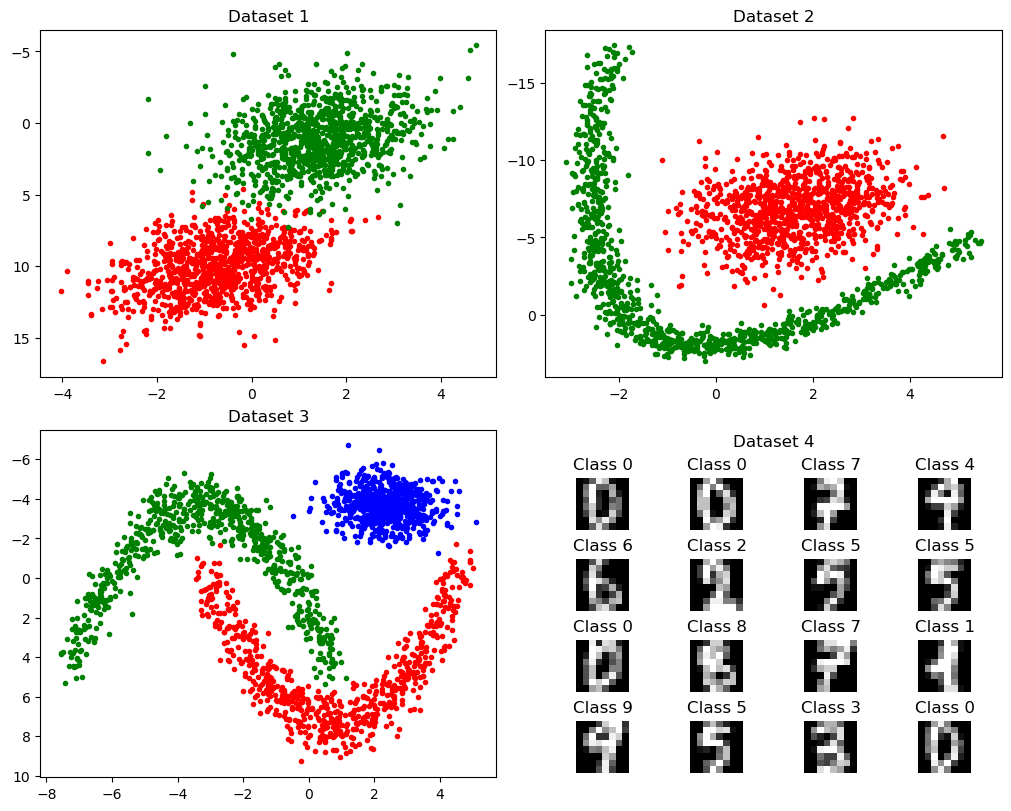

In [133]:
plotDatasets()

As you can see, datasets 1, 2 and 3 are point clouds with various shapes and number of classes, while dataset 4 consists of 8x8 pixel images of handwritten digits (these are stored as 64-length vectors). Each dataset in this assignment consists of three variables:
- `X` contains the input features for the data samples.
- `D` contains neural network target output values for the data samples. These are not used with kNN, and will be explained in the other notebooks in this assignment.
- `L` contains the class labels for the data samples.

Use the code in the next cell to load and examine all four datasets. Note that this assignment follows the convention that data samples are in the rows of a matrix, while features are in the columns.

In [134]:
datasetNr = 4
X, D, L = loadDataset(datasetNr)

print(f"X has shape {X.shape}")
print(f"D has shape {D.shape}")
print(f"L has shape {L.shape}")

X has shape (5620, 64)
D has shape (5620, 10)
L has shape (5620,)


#### **<span style="color:red">Question 1:</span>**
Describe all four datasets used in this assignment from a machine learning perspective:
- What does the dataset represent? What kind of data is it made of, and what can you tell about its arrangement?
- How many samples are in each dataset? How many features do they have?
- How many classes does each dataset have? What do they represent?
- Will the dataset require a linear or nonlinear classifier? Why?

#### **<span style="color:green">Answer:</span>**

    Dataset 1:
    We have 2000 samples with 2 features, meaning each data point lies in a 2-dimensional feature space. The dataset consists of 2 classes, which we want to classify the samples into. Each of the 2000 samples has an associated class label indicating which class it belongs to.
    From the plot we can see that the data points are clustered to 2 distinct clusters, with little spread meaning that linear classification would work well here, since a straight line in the plot is enough to separate the classes in a meaningful way.

    Dataset 2:
    Here we also have 2000 samples with 2 features, meaning that once again each data point lies in a 2D feature space. The dataset has 2 classes, and we want to classify the samples into one of these classes. We also have class labels for every data point which lets us know what class each sample belongs to.
    In the plot we can see that we have 1 cluster of data points that isn't too spread out, but then the other class of data points has a curved, moon-like shape. This tells us that linear classification isn't enough, since a straight line can't separate the two classes. Therefore we would need nonlinear classification.

    Dataset 3:
    This dataset contains 2000 samples with 2 features --> 2D feature space
    The target output D has 3 components, which indicates the dataset has 3 different classes and that each sample belongs to exactly one of these.
    From the plot we can see that two of the classes form curved, moon-like shapes while the third class forms a compact cluster. Due to the nonlinear structure of the classes, it is not possiible to seperate them using straight line. Therefore, we need to use a nonlinear classifier to correctly classify this dataset.

    Dataset 4:
    Here we have 5620 samples and 64 features (8x8 number of pixels) per sample, which means that each data point lies in a 64-dimensional feature space. From the shape of D we can say that there are 10 classes which makes sense because there are 10 digits.
    Due to the high dimensionality of the data and the complex visual patterns, the dataset is definitely not linearly separable. As a result, a more complex nonlinear classification method is required, like a neural network or kNN.



---
### **2. The kNN classifier**

k-nearest neighbors (kNN) is a relatively simple classification algorithm, that nevertheless can be quite effective. It is a nonlinear classifier where each new sample is assigned the class that most commonly appears among its neighbors in the training data, i.e. those training samples with the shortest distance to it. Distances in kNN can actually be defined in many different ways based on the application, but here we will use the most common Euclidean distance. The number of neighboring samples to consider, called k, is the only parameter of the algorithm. Depending on the specific properties of the problem, different values of k might give optimal results.

Unlike other types of classifiers, such as support vector machines and neural networks, kNN does not have any trainable parameters, and thus requires no training. It does, however, require a training dataset, which is effectively "memorized", and used as reference to classify all future data. This has the advantage of no training time, but results in slow inference times, which are proportional to the amount of training data.

#### **2.1 Implement the kNN algorithm**

The `kNN` function takes as input arguments the set of samples to be classified `X`, the number of neighbors to consider `k`, and the training samples `XTrain` and labels `LTrain`. There are different ways to implement the kNN algorithm, but we recommend you to follow these steps:

1. Calculate the Euclidean distances between every point in `X` and every point in `XTrain` and save them in a large matrix. Recall that the Eucliden distance between two $N$-dimensional points $\mathbf{x}$ and $\mathbf{y}$ is given as

$$ \large d = \sqrt{\sum_{i=1}^N (x_i - y_i)^2} .$$

Your implementation should not assume any specific number of features in the data, but should work for data of any number of features.

2. From each row of the matrix, select the `k` points with the smallest distance.

3. Find the class that appears most often among the `k` closest points and assign it to the corresponding point in `X`.

4. Sometimes there is a draw between two neighboring classes. Detect this and implement a strategy for choosing the class.

Keep in mind that, as was said previously, classifying data with kNN can be time-consuming, and an efficient implementation can really save you some time in the long run (especially once we implement cross-validation in section 3). Because of this, it is recommended that you avoid loops as much as possible, and instead take full advantage of `numpy`'s capacity for operating directly on arrays using either matrix multiplication or [broadcasting](https://numpy.org/doc/stable/user/basics.broadcasting.html). See some more instructions in the code cell below.

In [135]:
def kNN(X, k, XTrain, LTrain):
    """ KNN
    Your implementation of the kNN algorithm.

    Args:
        X (array): Samples to be classified.
        k (int): Number of neighbors.
        XTrain (array): Training samples.
        LTrain (array): Correct labels of each sample.

    Returns:
        LPred (array): Predicted labels for each sample.
    """

    classes = np.unique(LTrain)
    nClasses = classes.shape[0]

    # --------------------------------------------
    # === Your code here =========================
    # --------------------------------------------
    
    # Calculate all the distances between X and XTrain
    #   We strongly recommend to vectorize this part, i.e. to avoid loops since this will be very slow.
    #   There are several ways to do this, but we recommend one of the following:
    #   1) Using broadcasting. Look at the documentation at https://numpy.org/doc/stable/user/basics.broadcasting.html, and how to use np.newaxis
    #   2) Using matrix multiplication. Recall that ||a-b||^2 = ||a||^2 + ||b||^2 - 2*a.b, where a.b is the dot product
    
    # Compute squared distances using broadcasting
    X2 = np.sum(X**2, axis=1, keepdims=True) #Shape: (nTest, 1)
    XTrain2 = np.sum(XTrain**2, axis=1, keepdims=True) #Shape: (nTrain, 1)
    distances2 = X2 + XTrain2.T - 2 * np.dot(X, XTrain.T) #Shape: (nTest, nTrain)
        
    # Sort distances and find k closest labels
    sortedIndices = np.argsort(distances2, axis=1) #Shape: (nTest, nTrain)
    kIndices = sortedIndices[:, :k] #Shape: (nTest, k)
    kLabels = LTrain[kIndices] #Shape: (nTest, k)

    # Find the most common label and store it in LPred, making sure to handle ties appropriately
    nTest = kLabels.shape[0] #Number of test samples

    #Allocate LPred array
    LPred = np.empty(nTest, dtype=LTrain.dtype)

    # For each test sample
    for i in range(nTest):
        labels, counts = np.unique(kLabels[i], return_counts=True)
        maxCount = np.max(counts)

        #Labels that are tied for the most common
        tiedLabels = labels[counts == maxCount]

        #Majority vote
        if tiedLabels.size == 1:
            LPred[i] = tiedLabels[0]
        else:
            #Tie-break: Closest neighbor's class wins
            for label in kLabels[i]:
                if label in tiedLabels:
                    LPred[i] = label
                    break
                
    # ============================================
    
    return LPred

#### **2.2 Test it on some data**

In order to test your implementation, you will first need to split the available data into training and test sets. You can then classify the test data using the training data as reference. Use the `splitData` function for this purpose.

In [136]:
# Select and load dataset
datasetNr = 4
X, D, L = loadDataset(datasetNr)

# Split data into training set (85%) and test set (15%)
XTrain, _, LTrain, XTest, _, LTest = splitData(X, D, L, 0.15)

Set a value for `k` and classify the training and test data.

In [161]:
# Set the number of neighbors
k = 5

# Classify training data
LPredTrain = kNN(XTrain, k, XTrain, LTrain)
# Classify test data
LPredTest  = kNN(XTest , k, XTrain, LTrain)

Calculate and print the training and test accuracies as well as the confusion matrix for the test data. For this to work, you first need to open the file `evalFunctions.py` and implement the functions `calcAccuracy`, `calcConfusionMatrix`, and `calcAccuracyCM`, based on the function descriptions.

In [138]:
# Calculate the training and test accuracy
accTrain = calcAccuracy(LPredTrain, LTrain)
accTest = calcAccuracy(LPredTest, LTest)
print(f"Train accuracy: {accTrain:.4f}")
print(f"Test accuracy: {accTest:.4f}")

# Calculate confunsion matrix of test data
confMatrix = calcConfusionMatrix(LPredTest, LTest)
print()
print("Test data confusion matrix:")
print(confMatrix)

accTestCM = calcAccuracyCM(confMatrix)
print()
print(f"Test accuracy from CM: {accTestCM:.4f}")

Train accuracy: 0.9885
Test accuracy: 0.9846

Test data confusion matrix:
[[ 81   0   0   0   0   0   0   0   0   0]
 [  0  71   1   0   0   0   1   0   2   0]
 [  0   0  84   0   0   0   0   0   1   0]
 [  0   0   0  80   0   1   0   0   0   1]
 [  0   0   0   0  85   0   0   0   0   0]
 [  0   0   0   0   0 107   0   0   0   0]
 [  0   0   0   0   0   0  87   0   1   0]
 [  0   1   0   0   0   0   0  67   0   0]
 [  0   0   0   0   0   0   0   0  90   2]
 [  0   0   0   0   1   0   0   0   1  78]]

Test accuracy from CM: 0.9846


Now we can use some plotting functions to examine the classified training and test data, as well as the decision boundaries that separate the various classes. We will use these types of visualizations for all three classifier types.

For datasets 1-3 you will see classification results for the training and test data, where correctly classified samples appear in green and incorrectly classified samples appear in red. The backgrounds of these plots show in grayscale colors the different regions of the feature space which are assigned each class by the classifier. This is especially useful in order to examine the shape of the decision boundaries.

For the dataset 4 you will see a plot that shows examples of each type of correct and incorrect classification as given by the confusion matrix.

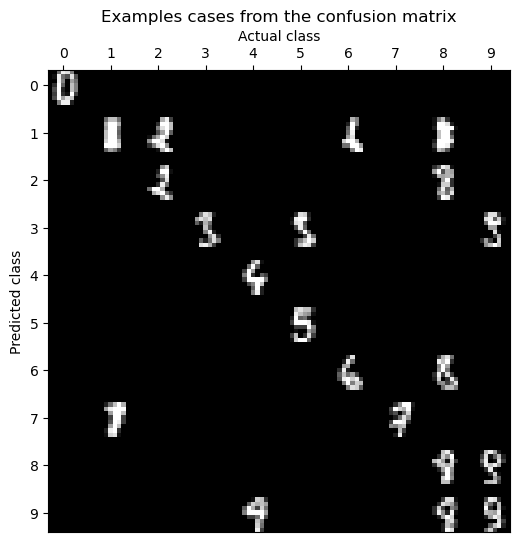

In [139]:
if datasetNr < 4:
    plotResultsDots(XTrain, LTrain, LPredTrain, XTest, LTest, LPredTest, lambda X: kNN(X, k, XTrain, LTrain))
else:
    plotConfusionMatrixOCR(XTest, LTest, LPredTest)

#### **<span style="color:red">Question 2:</span>**
- Describe how your kNN implementation works, step by step.

- Describe the way in which your implementation handles ties in the neighbor classes, that is, situations in which several classes are equally common among the neighbors of a point. For example, `k=4` and the classes of the neighbors are `[0,0,1,1]`, or `k=5` and the classes are `[1,1,2,3,3]`.

#### **<span style="color:green">Answer:</span>**

My implementation starts with computing the squared distance according to the formula listed in the lab code template. We never actually take the square root of the squared distance, because we only care about the closest neighbors, we don't actually care about the exact distance. This means we can just compare the square distances instead which will give exactly the same results. Then we sort the distances and get the indices for all distances (shortest --> longest). With this we can get the k closest indices for every label as well as the k closest labels. We then for each test sample, loop through the k closest labels and count how many times they appear and store the most common label in LPred. If we have a majority vote, then we have our prediction!

If we have a tie-break I just chose to take the 1 closest neighbor out of our tied classes as our prediction. So if we have k=4 with neighbors of classes [0,0,1,1], then we loop through the array of k closest neighbors (which is sorted by closest --> furthest away). The first match we get with the tied labels is the closest neighbor to one of the tie-breaking classes.

#### **2.3 Try kNN on all datasets**

Once you have made sure that your kNN implementation works correctly, we can define a function that performs all of the previous steps: it loads data, trains and evaluates a kNN on a specific dataset using your own kNN implementation, and prints the results. You can use it to experiment with applying your kNN implementation on all the datasets. Try experimenting with different values of `k` and note especially the effect that it has on the decision boundaries.

In [140]:
def runkNNOnDataset(datasetNr, testSplit, k):
    X, D, L = loadDataset(datasetNr)
    XTrain, _, LTrain, XTest, _, LTest = splitData(X, D, L, testSplit)

    LPredTrain = kNN(XTrain, k, XTrain, LTrain)
    LPredTest = kNN(XTest, k, XTrain, LTrain)
    
    accTrain = calcAccuracy(LPredTrain, LTrain)
    accTest = calcAccuracy(LPredTest, LTest)
    confMatrix = calcConfusionMatrix(LPredTest, LTest)
    
    print(f'Train accuracy: {accTrain:.4f}')
    print(f'Test accuracy: {accTest:.4f}')
    print("Test data confusion matrix:")
    print(confMatrix)

    if datasetNr < 4:
        plotResultsDots(XTrain, LTrain, LPredTrain, XTest, LTest, LPredTest, lambda X: kNN(X, k, XTrain, LTrain))
    else:
        plotConfusionMatrixOCR(XTest, LTest, LPredTest)

Train accuracy: 0.9935
Test accuracy: 0.9933
Test data confusion matrix:
[[166   1]
 [  1 132]]


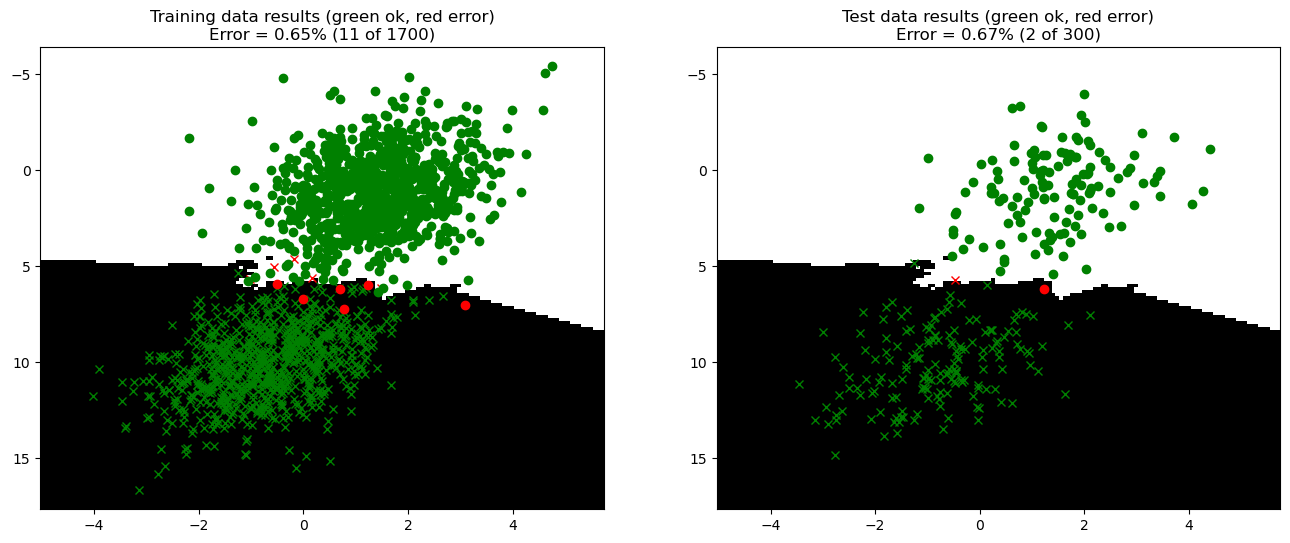

In [141]:
runkNNOnDataset(1, testSplit=0.15, k=3)

Train accuracy: 1.0000
Test accuracy: 1.0000
Test data confusion matrix:
[[143   0]
 [  0 157]]


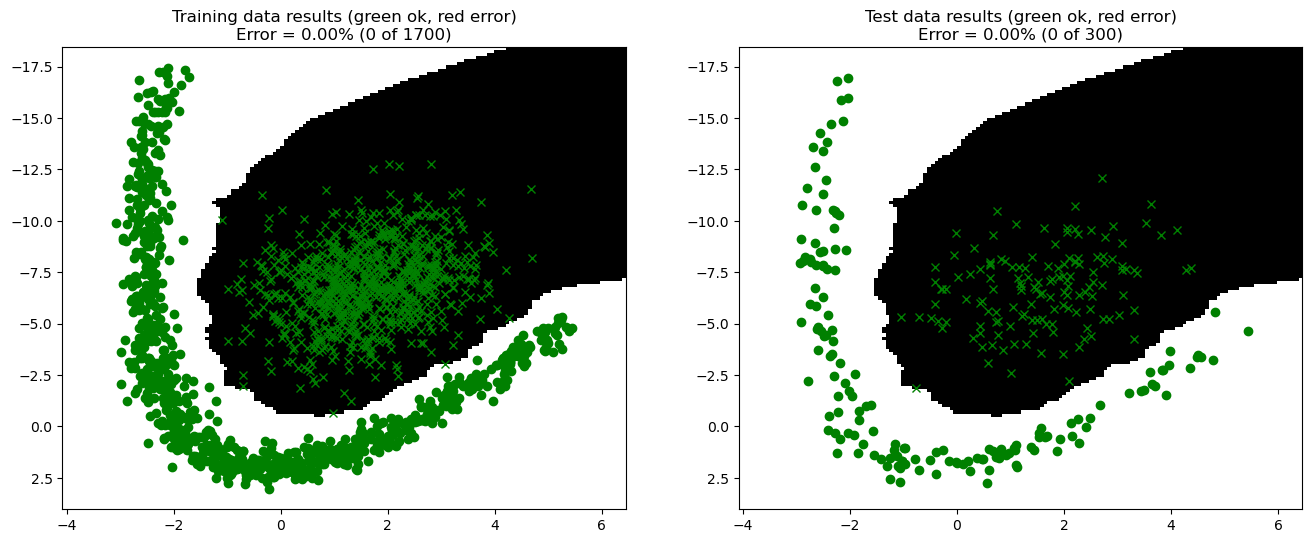

In [142]:
runkNNOnDataset(2, testSplit=0.15, k=3)

Train accuracy: 0.9988
Test accuracy: 1.0000
Test data confusion matrix:
[[ 96   0   0]
 [  0 107   0]
 [  0   0  97]]


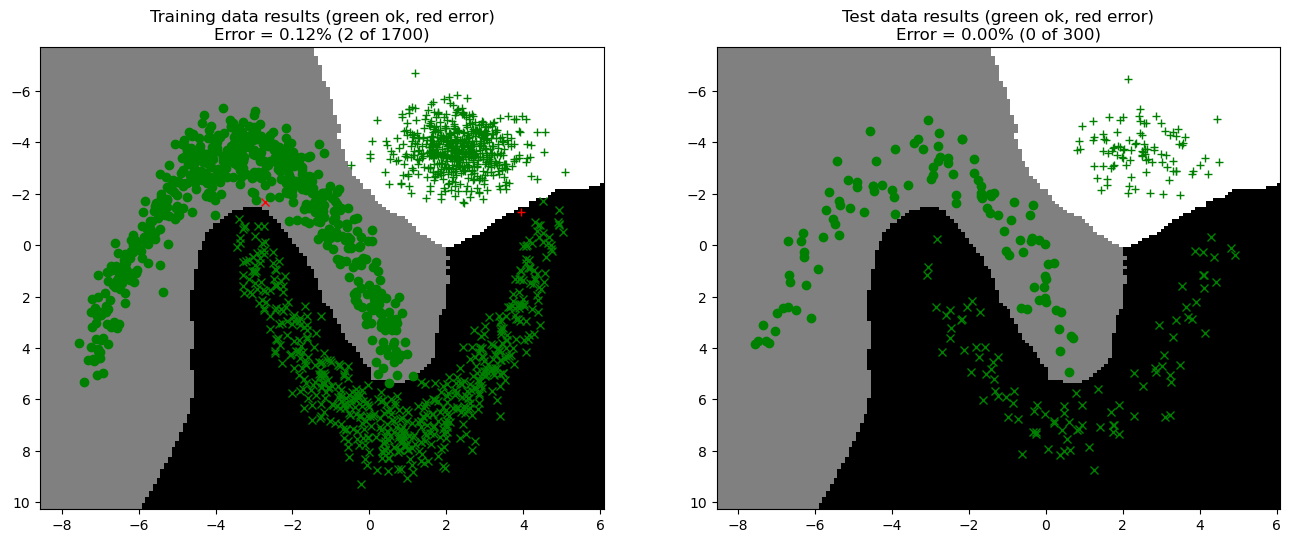

In [143]:
runkNNOnDataset(3, testSplit=0.15, k=10)

Train accuracy: 0.9851
Test accuracy: 0.9737
Test data confusion matrix:
[[415   0   0   0   0   0   0   0   0   0]
 [  0 427   2   0   3   0   1   2  18   6]
 [  0   1 408   2   0   0   0   0   4   1]
 [  0   1   0 421   0   2   0   1   4   7]
 [  1   0   0   0 404   0   0   1   0   1]
 [  0   0   0   4   0 391   0   0   1   2]
 [  1   0   0   0   2   0 420   0   2   0]
 [  0   1   1   2   1   0   0 417   0   1]
 [  0   0   4   1   0   0   0   2 395   3]
 [  0   2   0   1   4  14   0   2   2 406]]


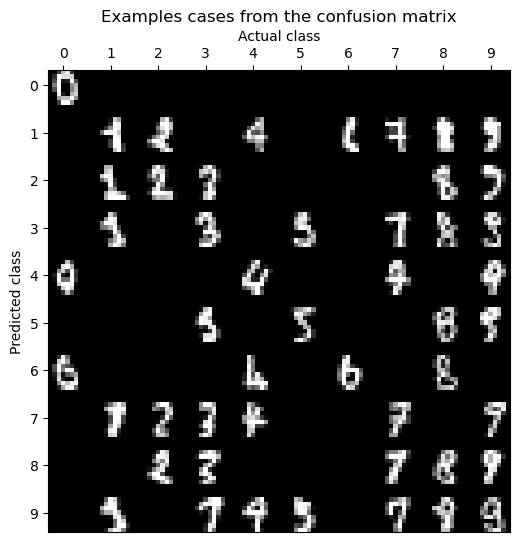

In [144]:
runkNNOnDataset(4, testSplit=0.75, k=10)

### **3. Cross-validation**

As mentioned previously, different values of `k` might work better or worse for each dataset. However, in order to establish which value is best for each dataset it is not enough to run kNN once for each `k` and select the one that gives the highest accuracy. This approach would not take into account the variations in performance that result from the random splitting of training and test data. Results obtained in this way will not reflect the performance that can be expected when the algorithm is applied on new data.

In order to thoroughly test which value of `k` is best we can resort to cross-validation methods, which rely on repeatedly testing the model on different splits of the data in order to assess its generalization performance. In particular, we will focus on n-fold cross-validation. In this method, we will first reserve a portion of the data for testing, `XTest`, which we will not touch until the very end, and use the remaining data `XTrain` for cross-validation. `XTrain` will again be split into `N` bins, which corresponds with the number of times that the kNN algorithm will be run for each value of `k`. For each iteration, one bin is used as validation data `XValCV`, and all the remaining bins are combined and used as training data `XTrainCV`. This will result in `N` accuracies for each value of `k`, which we will average to obtain the **average cross-validation accuracy**, which is the relevant metric for determining the optimal `k`. The higher the value of `N`, the more precise will be our determination of the accuracy of different values of `k`. This picture illustrates 3-fold cross validation for one value of `k`.

![](NotebookMaterial/CrossValidation.png)

After determining the value of `k` that gives the highest accuracy, we will use it to classify `XTest` using all of `XTrain` as reference data. This will give as the **test accuracy** of our model, and is the definitive metric representing its performance.

Start by splitting the available data into training and test `splitData` function as before. Then, use the function `splitDataBins` to further split the training data into `N` bins. Finally, use the funciton `getCVSplit` to combine the data bins into `XTrainCV` and `XValCV`. This function takes in the degree of cross validation `N` and the current iteration of the cross validation `i`, indicating which bin will be used for the validation data (note that this is zero-indexed). Three-fold cross-validation should be a minimum, but do not be afraid to try using more bins, e.g. 50-100, as the resulting inference time increases less than linearly.

In [156]:
# Select and load dataset
datasetNr = 3
X, D, L = loadDataset(datasetNr)

# Split data into training and test sets
XTrain, _, LTrain, XTest, _, LTest = splitData(X, D, L, 0.15)

# Select the number of bins to split the data
nBins = 10

# Split data into bins based on the settings above
# The outputs are lists of length nBins, where each item is a data array. Try printing for example XBins[0].shape.
XBins, _, LBins = splitDataBins(XTrain, None, LTrain, nBins)

Finish the implementation of the `crossValidation` function, which needs to take a maximum value of `k` and the cross validation bins and return a matrix containing the cross-validation accuracies obtained for different values of `k` and combinations of bins used for training.

In [157]:
def crossValiation(kMax, XBins, LBins):
    """Performs cross-validation using kNN

    Args:
        kMax (int): Maximum value of k to test. Values used will be [1-kMax].
        XBins (list of arrays): Training+validation data samples.
        LBins (list of arrays): Training+validation data labels.

    Returns:
        meanAccs (array): Cross-validation accuracies. Bins are in the rows, and
            values of k in the columns.
        kBest (int): Optimal value of k based on cross validation results.
    """

    nBins = len(XBins)
    accs = np.zeros((nBins, kMax))

    # This is used to show the progress
    timeStart = tic()

    # --------------------------------------------
    # === Your code here ========================= def kNN(X, k, XTrain, LTrain):
    # --------------------------------------------
    for b in range(nBins):
        
        # Use getCVSplit to combine bins for training and validation data
        XTrainCV, _, LTrainCV, XValCV, _, LValCV = getCVSplit(XBins, None, LBins, nBins, b)
        
        for k in range(kMax):

            # Classify validation data using kNN
            LPredVal = kNN(XValCV, k+1, XTrainCV, LTrainCV) #k+1 because k starts from 0
            
            # ... and store resulting accuracy in the accs matrix
            accs[b, k] = calcAccuracy(LPredVal, LValCV)
            
            # Print progress and remaining time
            timeLeft = round((tic()-timeStart)*( nBins*kMax / (b*kMax + k + 1) - 1))
            etaStr = str(timedelta(seconds=timeLeft))
            print(f"b: {b+1:2}, k: {k+1:2}, ETA: {etaStr}    ", end="\r")
    
    # Compute the mean cross validation accuracy for each k
    meanAccs = np.mean(accs, axis=0)
    
    # And find the best k
    kBest = np.argmax(meanAccs) + 1 #+1 because indexes start from 0, but k starts from 1
    
    # ============================================
    
    return meanAccs, kBest

Test your cross-validation implementation and look at the resulting performance plot. This shows the average cross-validation accuracy for all the values of `k` tested.

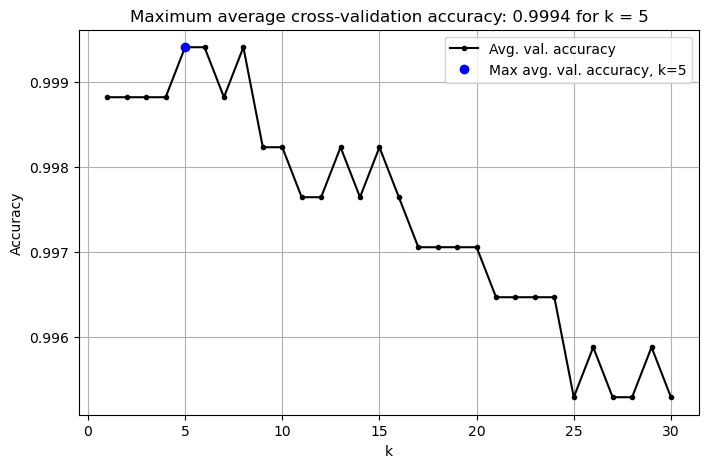

In [160]:
meanAccs, kBest = crossValiation(30, XBins, LBins)
plotResultsCV(meanAccs, kBest)

After selecting the optimal value of `k` using cross-validation, use this value to classify `XTest` using the data in `XTrain` as reference to obtain the test accuracy.

In [163]:
LPredTest = kNN(XTest, kBest, XTrain, LTrain)

confMatrix = calcConfusionMatrix(LPredTest, LTest)
acc = calcAccuracy(LPredTest, LTest)

print(k)

print(f"Test accuracy: {acc:.4f}")
print("Test data confusion matrix:")
print(confMatrix)

5
Test accuracy: 0.9967
Test data confusion matrix:
[[113   0   0]
 [  1  91   0]
 [  0   0  95]]


#### **<span style="color:red">Question 3:</span>**
- Describe how you implemented cross-validation.

#### **<span style="color:green">Answer:</span>**

I started with iterating through each bin of data. I then split into the relevant data by using the getCVSplit() function. I then iterate through every k up until kMax (so now we have a nested loop). We classify the validation data using the kNN function that I coded earlier and store the accuracy in the accs matrix. We then do some prints just to be able to debug while the crossvalidation function is running. After this we calculate the average acc for every k, and finally select the best k.

---
### **4. Cross validation for all datasets**

Once again we define a single function that performs all of the previous cross-validation for a given dataset and shows the results. Use it to perform cross-validation on all four datasets.

In [164]:
def runkNNCrossValidationOnDataset(datasetNr, testSplit, nBins, kMax):
    X, D, L = loadDataset(datasetNr)
    XTrain, _, LTrain, XTest, _, LTest = splitData(X, D, L, testSplit)
    XBins, _, LBins = splitDataBins(XTrain, None, LTrain, nBins)

    meanAccs, kBest = crossValiation(kMax, XBins, LBins)
    plotResultsCV(meanAccs, kBest)

    LPredTrain = kNN(XTrain, kBest, XTrain, LTrain)
    LPredTest = kNN(XTest, kBest, XTrain, LTrain)
    confMatrix = calcConfusionMatrix(LPredTest, LTest)
    accTest = calcAccuracy(LPredTest, LTest)

    print(f'Test accuracy: {accTest:.4f}')
    print("Test data confusion matrix:")
    print(confMatrix)

    if datasetNr < 4:
        plotResultsDots(XTrain, LTrain, LPredTrain, XTest, LTest, LPredTest, lambda X: kNN(X, kBest, XTrain, LTrain))
    else:
        plotConfusionMatrixOCR(XTest, LTest, LPredTest)
        

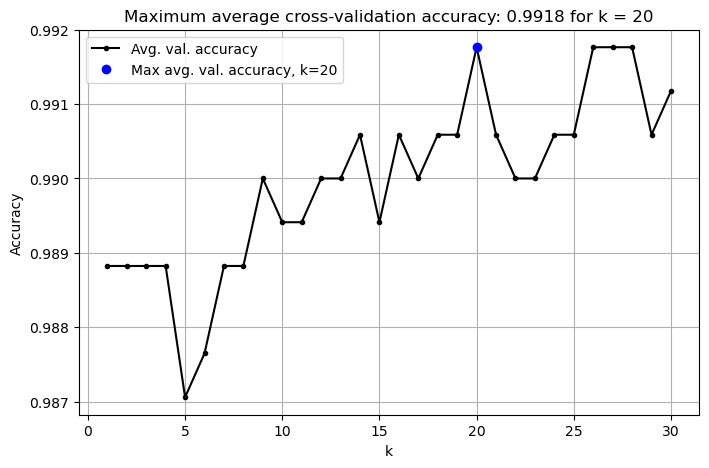

Test accuracy: 0.9933
Test data confusion matrix:
[[152   1]
 [  1 146]]


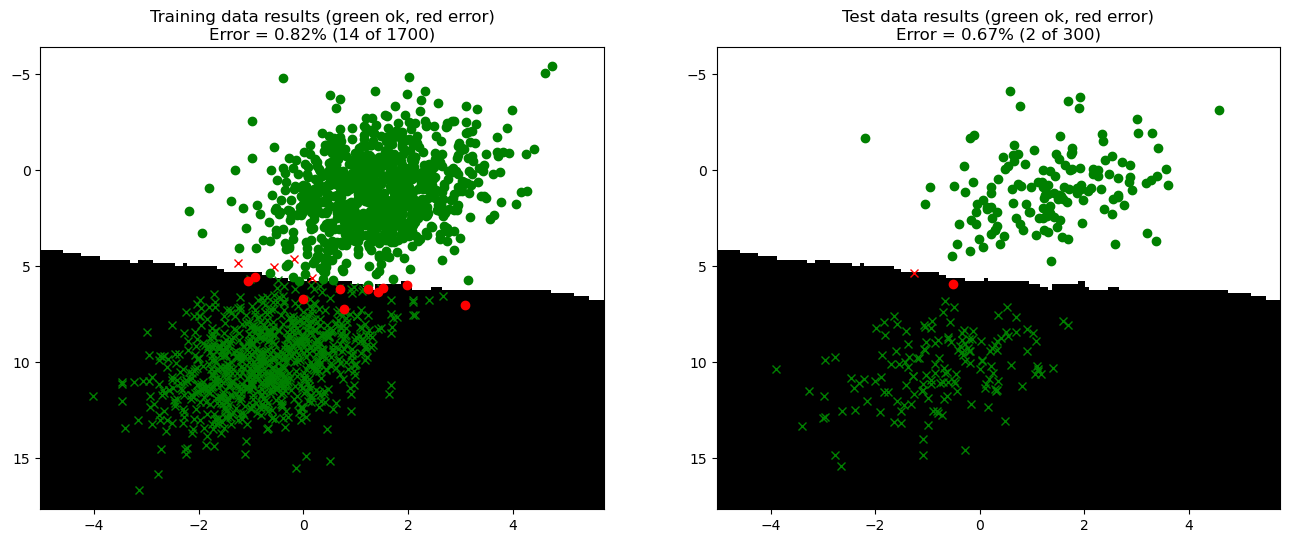

In [165]:
runkNNCrossValidationOnDataset(1, testSplit=0.15, nBins=20, kMax=30)

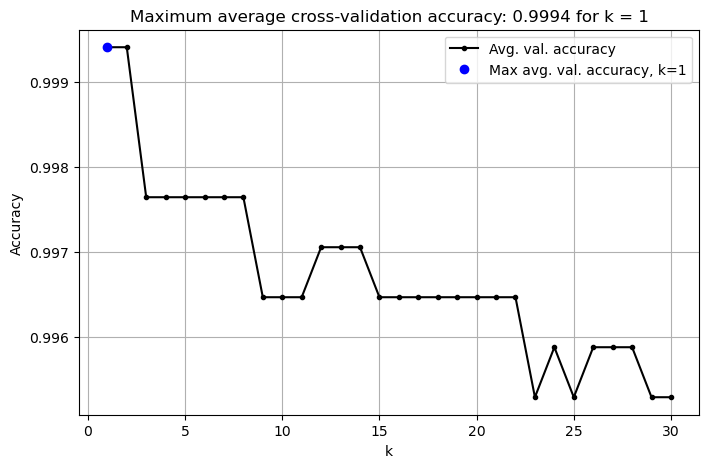

Test accuracy: 1.0000
Test data confusion matrix:
[[158   0]
 [  0 142]]


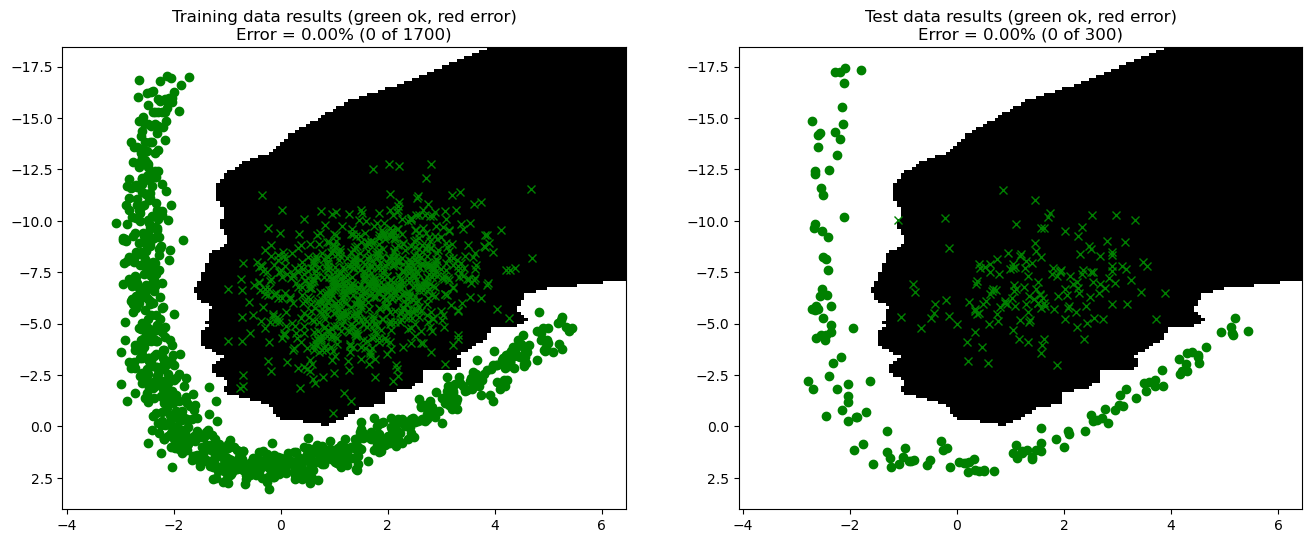

In [166]:
runkNNCrossValidationOnDataset(2, testSplit=0.15, nBins=20, kMax=30)

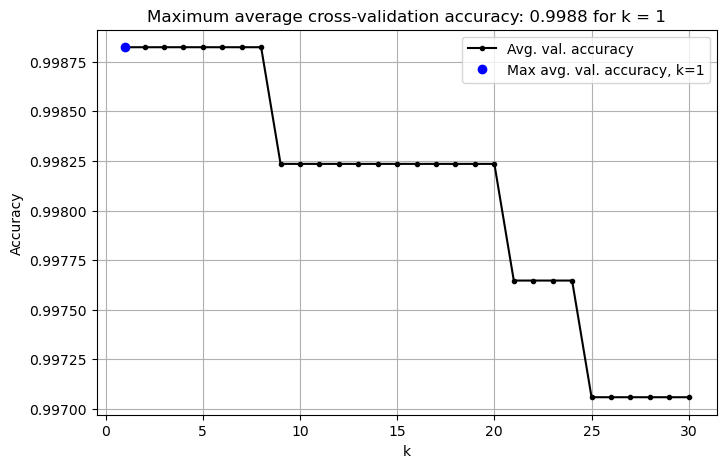

Test accuracy: 0.9967
Test data confusion matrix:
[[100   0   0]
 [  1  99   0]
 [  0   0 100]]


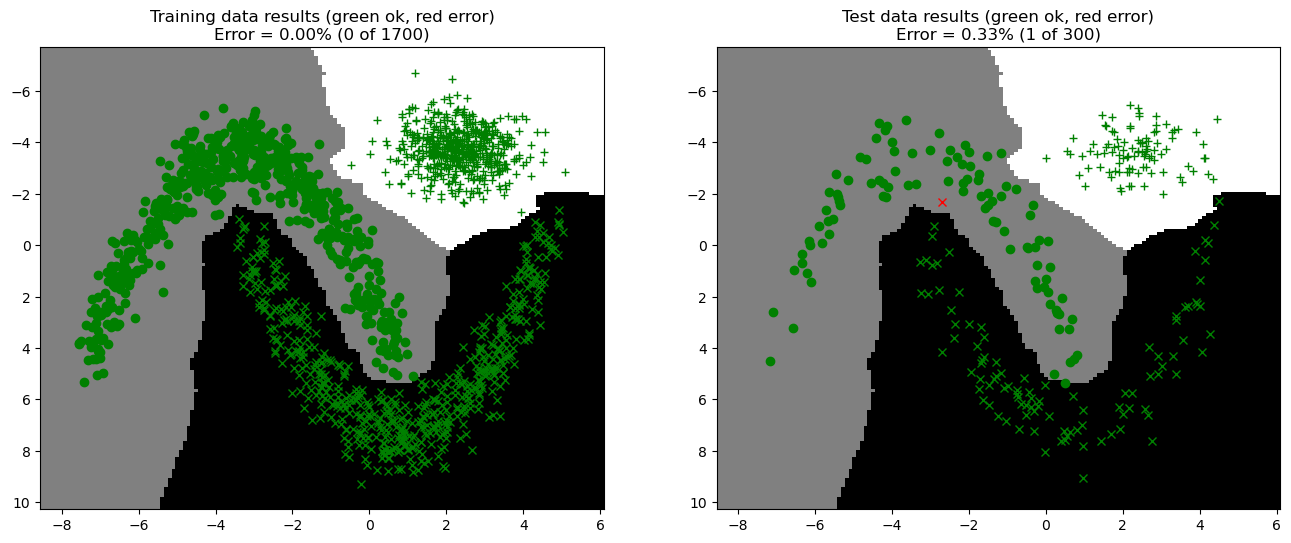

In [167]:
runkNNCrossValidationOnDataset(3, testSplit=0.15, nBins=20, kMax=30)

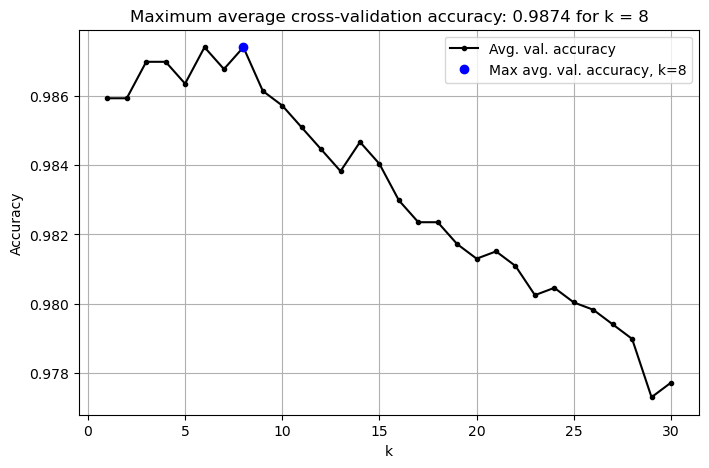

Test accuracy: 0.9870
Test data confusion matrix:
[[67  0  0  0  1  0  0  0  0  0]
 [ 0 86  0  0  0  0  0  0  1  0]
 [ 0  0 79  0  0  0  0  0  0  0]
 [ 0  0  0 89  0  0  0  0  0  1]
 [ 1  0  0  0 94  0  0  0  0  0]
 [ 0  0  0  0  0 81  0  0  0  0]
 [ 0  0  0  0  1  0 85  0  0  0]
 [ 0  1  0  0  0  0  0 83  0  0]
 [ 0  0  0  0  0  0  0  0 81  0]
 [ 0  0  0  0  1  3  0  1  0 87]]


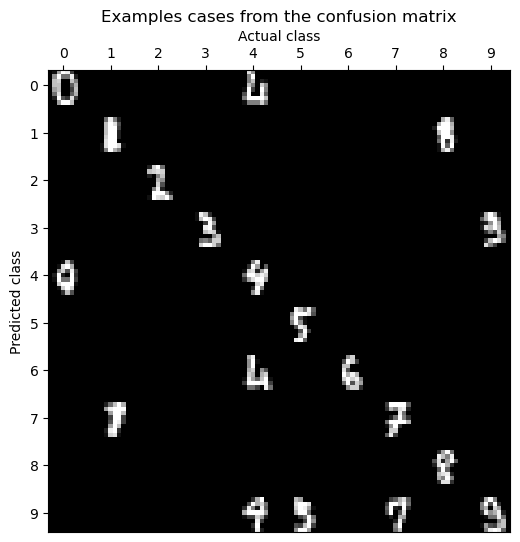

In [168]:
runkNNCrossValidationOnDataset(4, testSplit=0.15, nBins=20, kMax=30)

#### **<span style="color:red">Question 4:</span>**
- Comment on the results for each dataset. What is the optimal k, and are those results reasonable?

#### **<span style="color:green">Answer:</span>**

Results:
Dataset 1: k=20 optimal
Dataset 2: k=1 optimal (k=2 gives similar performance)
Dataset 3: k=1 optimal (k values up to ~8 give similar performance)
Dataset 4: k = 8 optimal

I would say that these results look reasonable in general, but I was surprised that k=1 gives such good results for dataset 2 & 3. I think this isn't anything incorrect, but rather because of the datasets have classes that are easily separated. If we were to have more spread out data, then it would probably be wiser to choose a slightly higher k for dataset 2 and 3, because it makes the algorithm less affected by noise.

That k=20 is optimal for dataset 1 and k=8 optimal for dataset 4 seems reasonable to me as well, and I see no reason to question the result. Especially since the difference in test accuracy we're seeing between the optimal k and other k values are very small (<1 percentage point for datasets 1-3, ~1 percentage point for dataset 4).